In [2]:
%load_ext autoreload
%autoreload 2


from glob import glob
from itertools import chain, combinations
import math

import ensembl_rest
import numpy as np
import pandas as pd
from sourmash import load_signatures


import tqdm

In [3]:
from Bio import SeqIO

import seaborn as sns

In [4]:
GENCODE = "/home/olga/data_lg/czbiohub-reference/gencode"

In [5]:
ls $GENCODE/human/v30

gencode.v30.annotation.ERCC92.gene_type.gtf*
gencode.v30.annotation.ERCC92.gtf*
gencode.v30.annotation.gtf*
gencode.v30.pc_translations.fa.gz
gencode.v30.transcripts.ERCC92.fa*
gencode.v30.transcripts.fa*
getfasta_transcript_test.fa*
GRCh38.p12.genome.ERCC92.fa*
GRCh38.p12.genome.fa*
GRCh38.p12.genome.fa.fai*
Makefile*
Makefile~*
salmon_index/
STARIndex/
test_gffread_transcripts.fa*
test_gffread_transcripts_no_dashF.fa*
w*


In [6]:
ls $GENCODE/mouse/vM21

gencode.vM21.annotation.ERCC92.gene_type.gtf*  GRCm38.p6.genome.ERCC92.fa.fai*
gencode.vM21.annotation.ERCC92.gtf*            GRCm38.p6.genome.fa*
gencode.vM21.annotation.gtf*                   GRCm38.p6.genome.fa.fai*
gencode.vM21.pc_translations.fa.gz             GRCm38.p6.genome.fa.gz*
gencode.vM21.transcripts.ERCC92.fa*            Makefile*
gencode.vM21.transcripts.fa*                   Makefile~*
GRCm38.p6.genome.chr19.fa*                     STARIndex/
GRCm38.p6.genome.ERCC92.fa*


In [7]:
import gzip

def parse_fasta_gz(fasta_gz):
    with gzip.open(fasta_gz, "rt") as f:
        records = [(x.id, str(x.seq)) for x in SeqIO.parse(f, format='fasta')]
    return records

human_peptides = parse_fasta_gz(f"{GENCODE}/human/v30/gencode.v30.pc_translations.fa.gz")
print(f"len(human_peptides): {len(human_peptides)}")

mouse_peptides = parse_fasta_gz(f"{GENCODE}/mouse/vM21/gencode.vM21.pc_translations.fa.gz")
print(f"len(mouse_peptides): {len(mouse_peptides)}")

len(human_peptides): 99731
len(mouse_peptides): 66650


In [8]:
human_peptides[:2]

[('ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326',
  'MKKVTAEAISWNESTSETNNSMVTEFIFLGLSDSQELQTFLFMLFFVFYGGIVFGNLLIVITVVSDSHLHSPMYFLLANLSLIDLSLSSVTAPKMITDFFSQRKVISFKGCLVQIFLLHFFGGSEMVILIAMGFDRYIAICKPLHYTTIMCGNACVGIMAVTWGIGFLHSVSQLAFAVHLLFCGPNEVDSFYCDLPRVIKLACTDTYRLDIMVIANSGVLTVCSFVLLIISYTIILMTIQHRPLDKSSKALSTLTAHITVVLLFFGPCVFIYAWPFPIKSLDKFLAVFYSVITPLLNPIIYTLRNKDMKTAIRQLRKWDAHSSVKF'),
 ('ENSP00000334393.3|ENST00000335137.4|ENSG00000186092.6|OTTHUMG00000001094.4|-|OR4F5-201|OR4F5|305',
  'MVTEFIFLGLSDSQELQTFLFMLFFVFYGGIVFGNLLIVITVVSDSHLHSPMYFLLANLSLIDLSLSSVTAPKMITDFFSQRKVISFKGCLVQIFLLHFFGGSEMVILIAMGFDRYIAICKPLHYTTIMCGNACVGIMAVTWGIGFLHSVSQLAFAVHLLFCGPNEVDSFYCDLPRVIKLACTDTYRLDIMVIANSGVLTVCSFVLLIISYTIILMTIQHRPLDKSSKALSTLTAHITVVLLFFGPCVFIYAWPFPIKSLDKFLAVFYSVITPLLNPIIYTLRNKDMKTAIRQLRKWDAHSSVKF')]

In [9]:
DAYHOFF_MAPPING = {
    "C": "a",
    
    # Small
    "A": "b",
    "G": "b",
    "P": "b",
    "S": "b",
    "T": "b",
    
    # Acid and amide
    "D": "c",
    "E": "c",
    "N": "c",
    "Q": "c",
    
    # Basic
    "H": "d",
    "K": "d",
    "R": "d",
    
    # Hydrophobic
    "I": "e",
    "L": "e",
    "M": "e",
    "V": "e",
    
    # Aromatic
    "F": "f",
    "W": "f",
    "Y": "f"
}

## Hydrophobic/hydrophilic mapping
HP_MAPPING = {
    # Hydrophobic
    "A": "h",
    "F": "h",
    "G": "h",
    "I": "h",
    "L": "h",
    "M": 'h',
    "P": "h",
    "V": "h",
    "W": "h",
    "Y": "h",
    
    # Hydrophilic - polar
    "N": 'p',
    "C": 'p',
    "G": "p",
    "S": "p",
    "T": "p",
    "D": "p",
    "E": "p",
    "R": "p",
    "H": "p",
    "K": "p",
    "Q": "p"
}
len(HP_MAPPING)

20

In [10]:
DAYHOFF_TRANSLATION = str.maketrans(DAYHOFF_MAPPING)

HP_TRANSLATION = str.maketrans(HP_MAPPING)

def dayhoffize(seq):
    return seq.translate(DAYHOFF_TRANSLATION)

def hpize(seq):
    return seq.translate(HP_TRANSLATION)

seq = "MKKVTAEAISWNESTSETN"
print(seq)
print(dayhoffize(seq))
print(hpize(seq))

MKKVTAEAISWNESTSETN
eddebbcbebfccbbbcbc
hpphphphhphpppppppp


 | Amino acid    | Property              | Dayhoff |
 |---------------|-----------------------|---------|
 | C             | Sulfur polymerization | a       |
 | A, G, P, S, T | Small                 | b       |
 | D, E, N, Q    | Acid and amide        | c       |
 | H, K, R       | Basic                 | d       |
 | I, L, M, V    | Hydrophobic           | e       |
 | F, W, Y       | Aromatic              | f       |


In [11]:
%%time

KSIZES = 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18
COLUMNS = 'id1', 'id2', 'ksize', 'jaccard'

def kmerize(seq, ksize):
    return set(seq[i:i+ksize] for i in range(len(seq)-ksize+1))

def jaccardize(set1, set2):
    denominator = min(len(set1), len(set2))
    if denominator > 0:
        return len(set1.intersection(set2))/denominator
    else:
        return denominator

def kmerize_and_jaccard(seq1, seq2, ksize, debug=False):
    kmers1 = set(seq1[i:i+ksize] for i in range(len(seq1)-ksize+1))
    kmers2 = set(seq2[i:i+ksize] for i in range(len(seq2)-ksize+1))
    jaccard = jaccardize(kmers1, kmers2)
    if debug:
        print("len(kmers1):", len(kmers1))
        print("len(kmers2):", len(kmers2))
        print(f"jaccard: {jaccard}")
    return jaccard


def kmer_comparison_table(id1, seq1, id2, seq2, molecule, ksizes=KSIZES):
    lines = []
    for ksize in ksizes:
        jaccard = kmerize_and_jaccard(seq1, seq2, ksize)
        line = [id1, id2, ksize, jaccard]
        lines.append(line)
    df = pd.DataFrame(lines, columns=COLUMNS)
    df['molecule'] = molecule
    return df


def nCr(n, r):
    f = math.factorial
    return f(n) // (f(r) * f(n - r))

total = nCr(len(input_seqs), 2)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 23.6 µs


## Multiprocessing!!

In [22]:
%debug

> /home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/multiprocessing/pool.py(735)next()
    733         if success:
    734             return value
--> 735         raise value
    736 
    737     __next__ = next                    # XXX



ipdb>  dir()


['item', 'self', 'success', 'timeout', 'value']


ipdb>  a


self = <multiprocessing.pool.IMapIterator object at 0x7f23a3051198>
timeout = None


ipdb>  print(value)


name 'id_seq1' is not defined


ipdb>  print(success)


False


ipdb>  u


> <ipython-input-21-db1c41214a55>(96)<module>()
     94 
     95 
---> 96 peptide_kmer_comparisons = pd.concat(chain(*result), ignore_index=True)
     97 
     98 notify(f"Total time: {time.time() - t0}")



ipdb>  q


In [28]:
# %%time
import time

from sourmash.logging import notify

from functools import partial
import itertools
import multiprocessing




def compare_peptide_seqs(id1_seq1, id2_seq2, ksizes=KSIZES):
    # Unpack the tuples
    id1, seq1 = id1_seq1
    id2, seq2 = id2_seq2
    
    protein_df = kmer_comparison_table(id1, seq1, id2, seq2, molecule='protein')
    
    dayhoff1 = dayhoffize(seq1)
    dayhoff2 = dayhoffize(seq2)
    
    dayhoff_df = kmer_comparison_table(id1, dayhoff1, id2, dayhoff2, 
                                       molecule='dayhoff')
    
    hp1 = hpize(seq1)
    hp2 = hpize(seq2) 
    
    hp_df = kmer_comparison_table(id1, hp1, id2, hp2, 
                                       molecule='hydrophilic-polar')
    df = pd.concat([protein_df, dayhoff_df, hp_df], ignore_index=True)
    return df

def compare_args_unpack(args, ksizes):
    """Helper function to unpack the arguments. Written to use in pool.imap as it
    can only be given one argument."""
    return compare_peptide_seqs(*args, ksizes=ksizes)


def get_comparison_at_index(index, seqlist, ksizes=KSIZES):
    """Returns similarities of all the combinations of signature at index in the
    siglist with the rest of the indices starting at index + 1. Doesn't redundantly
    calculate signatures with all the other indices prior to index - 1

    :param int index: generate masks from this image
    :param boolean ignore_abundance
        If the sketches are not abundance weighted, or ignore_abundance=True,
        compute Jaccard similarity.

        If the sketches are abundance weighted, calculate a distance metric
        based on the cosine similarity.
    :param boolean downsample by max_hash if True
    :param siglist list of signatures
    :return: list of similarities for the combinations of signature at index with
    rest of the signatures from index+1
    """
    startt = time.time()
    seq_iterator = itertools.product([seqlist[index]], seqlist[index + 1:])
    func = partial(compare_args_unpack, ksizes=ksizes)
    comparision_df_list = list(map(func, seq_iterator))
    notify(
        "comparison for index {} done in {:.5f} seconds",
        index,
        time.time() - startt,
        end='\r')
    return comparision_df_list

In [41]:
n_seqs = 100

human_subset = human_peptides[:n_seqs]
mouse_subset = mouse_peptides[:n_seqs]


input_seqs = human_subset + mouse_subset


In [42]:
dfs = [compare_peptide_seqs(x, y) for x, y in itertools.combinations(input_seqs[:2], 2)]
asdf = pd.concat(dfs, ignore_index=True)
print(asdf.shape)
asdf.head()

(51, 5)


,id1,id2,ksize,jaccard,molecule
0,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,2,1.0,protein
1,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,3,1.0,protein
2,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,4,1.0,protein
3,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,5,1.0,protein
4,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,6,1.0,protein


In [43]:
seqlist = human_peptides + mouse_peptides
len(seqlist)

166381

## This below is what broke and took forever...

In [ ]:
n_jobs = 32

t0 = time.time()
length_seqlist = len(seqlist)

# Initialize the function using func.partial with the common arguments like
# siglist, ignore_abundance, downsample, for computing all the signatures
# The only changing parameter that will be mapped from the pool is the index
func = partial(
    get_comparison_at_index,
    seqlist=seqlist,
    ksizes=KSIZES)
notify("Created similarity func")

# Initialize multiprocess.pool
pool = multiprocessing.Pool(processes=n_jobs)

# Calculate chunk size, by default pool.imap chunk size is 1
chunksize, extra = divmod(length_seqlist, n_jobs)
if extra:
    chunksize += 1
notify("Calculated chunk size for multiprocessing")

# This will not generate the results yet, since pool.imap returns a generator
result = pool.imap(func, range(length_seqlist), chunksize=chunksize)
notify("Initialized multiprocessing pool.imap")


peptide_kmer_comparisons = pd.concat(chain(*result), ignore_index=True)

notify(f"Total time: {time.time() - t0}")

Created similarity func
Calculated chunk size for multiprocessing
Initialized multiprocessing pool.imap


In [ ]:
3+1

In [ ]:
(13.9/1000**2) * 10000**2

In [121]:
len(dfs)

19900

In [123]:
# (1.33/100) * (len(human_peptides) + len(mouse_peptides))*/60/60

In [125]:
peptide_kmer_comparisons.shape

(835800, 5)

In [124]:
peptide_kmer_comparisons.head()

,id1,id2,ksize,jaccard,molecule
0,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,2,1.0,protein
1,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,3,1.0,protein
2,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,4,1.0,protein
3,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,5,1.0,protein
4,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSP00000334393.3|ENST00000335137.4|ENSG000001...,6,1.0,protein


In [129]:
peptide_kmer_comparisons.id1.head().values

array(['ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326',
       'ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326',
       'ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326',
       'ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326',
       'ENSP00000493376.2|ENST00000641515.2|ENSG00000186092.6|OTTHUMG00000001094.4|OTTHUMT00000003223.4|OR4F5-202|OR4F5|326'],
      dtype=object)

In [136]:
gene_metadata = peptide_kmer_comparisons.id1.drop_duplicates().str.split("|", expand=True)

columns = ['protein_id', 'transcript_id', 'gene_id', 
           'ott_gene', 'ott_transcript', 
           'transcript_name', 'gene_name', 'peptide_length']
renamer = dict(zip(range(len(columns)), columns))
gene_metadata = gene_metadata.rename(columns=renamer)
print(gene_metadata.shape)
gene_metadata.head()

(199, 8)


,protein_id,transcript_id,gene_id,ott_gene,ott_transcript,transcript_name,gene_name,peptide_length
0,ENSP00000493376.2,ENST00000641515.2,ENSG00000186092.6,OTTHUMG00000001094.4,OTTHUMT00000003223.4,OR4F5-202,OR4F5,326
8358,ENSP00000334393.3,ENST00000335137.4,ENSG00000186092.6,OTTHUMG00000001094.4,-,OR4F5-201,OR4F5,305
16674,ENSP00000409316.1,ENST00000426406.3,ENSG00000284733.1,OTTHUMG00000002860.3,OTTHUMT00000007999.3,OR4F29-201,OR4F29,312
24948,ENSP00000329982.2,ENST00000332831.4,ENSG00000284662.1,OTTHUMG00000002581.3,OTTHUMT00000007334.3,OR4F16-201,OR4F16,312
33180,ENSP00000411579.2,ENST00000420190.6,ENSG00000187634.12,OTTHUMG00000040719.11,OTTHUMT00000316521.3,SAMD11-203,SAMD11,358


In [137]:
gene_metadata.gene_name.unique()

array(['OR4F5', 'OR4F29', 'OR4F16', 'SAMD11', 'NOC2L', 'KLHL17',
       'PLEKHN1', 'PERM1', 'HES4', 'ISG15', 'AGRN', 'RNF223', 'C1orf159',
       'TTLL10', 'TNFRSF18', 'TNFRSF4', 'SDF4', 'B3GALT6', 'C1QTNF12',
       'UBE2J2', 'SCNN1D', 'ACAP3', 'PUSL1', 'INTS11', 'Xkr4', 'Rp1',
       'Sox17', 'Mrpl15', 'Lypla1', 'Gm37988', 'Tcea1', 'Rgs20',
       'Atp6v1h', 'Oprk1', 'Npbwr1', 'Rb1cc1', 'Alkal1', 'St18', 'Pcmtd1',
       'Sntg1', 'Rrs1', 'Adhfe1', 'Vxn', 'Mybl1', 'Vcpip1', 'Sgk3',
       'Mcmdc2', 'Tcf24', 'Ppp1r42'], dtype=object)

In [138]:
gene_metadata.gene_name.nunique()

49

In [139]:
gene_metadata.gene_name.str.lower().nunique()

49

In [133]:
len(human_peptides[0][1])

326

In [ ]:
gene_metadata = peptide_kmer_comparisons.id1

In [127]:
peptide_kmer_comparisons.id1.nunique()

199

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


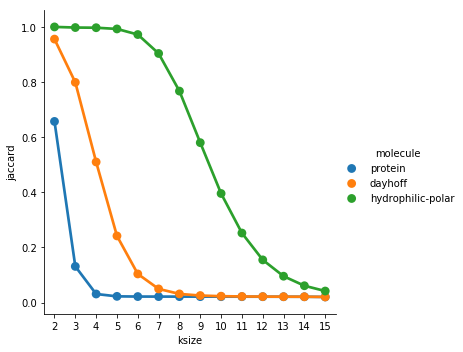

In [126]:
peptide_kmer_comparisons.id1.nunique, data=peptide_kmer_comparisons, hue='molecule')

/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/home/olga/miniconda3/envs/kmer-hashing/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


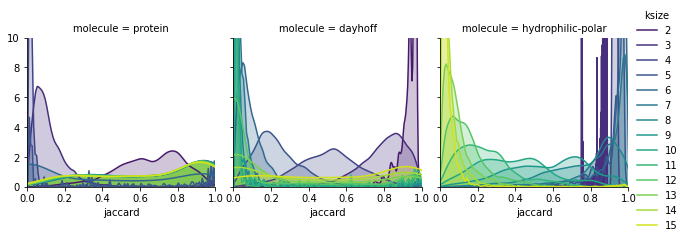

In [128]:
peptide_kmer_comparisons_kdeable = peptide_kmer_comparisons.query('(jaccard > 0) & (jaccard < 1)')

g = sns.FacetGrid(peptide_kmer_comparisons_kdeable, col='molecule', hue='ksize', 
                  palette='viridis')
g.map(sns.kdeplot, 'jaccard', shade=True)
g.set(xlim=(0, 1), ylim=(0, 10))
g.add_legend()

In [ ]:
g = sns.FacetGrid(peptide_kmer_comparisons, col='molecule', hue='ksize', 
                  palette='viridis')
g.map(sns.kdeplot, 'jaccard')
g.set(xlim=(0, 1), ylim=(0, 10))
g.add_legend()

In [69]:
np

NameError: name 'np' is not defined

In [68]:
peptide_kmer_comparisons_gr0 = peptide_kmer_comparisons.query('jaccard > 0')
print(peptide_kmer_comparisons_gr0.shape)
peptide_kmer_comparisons_gr0.head()

(1687, 5)


,id1,id2,ksize,jaccard,molecule
0,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSMUSP00000070648.4|ENSMUST00000070533.4|ENSM...,2,0.777202,protein
1,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSMUSP00000070648.4|ENSMUST00000070533.4|ENSM...,3,0.130719,protein
2,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSMUSP00000070648.4|ENSMUST00000070533.4|ENSM...,4,0.006211,protein
8,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSMUSP00000070648.4|ENSMUST00000070533.4|ENSM...,2,1.000000,dayhoff
9,ENSP00000493376.2|ENST00000641515.2|ENSG000001...,ENSMUSP00000070648.4|ENSMUST00000070533.4|ENSM...,3,0.883929,dayhoff


ValueError: zero-size array to reduction operation minimum which has no identity

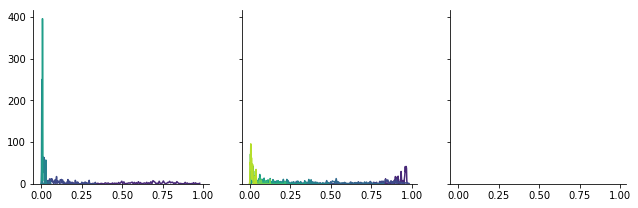

In [67]:
g = sns.FacetGrid(peptide_kmer_comparisons_gr0, col='molecule', hue='ksize', 
                  palette='viridis')
g.map(sns.kdeplot, 'jaccard', clip=(0, 1), bw=0.001)
g.set(xlim=(0, 1), ylim=(0, 10))
g.add_legend()

In [134]:
source_dayhoff = source_seq.translate(dayhoff_mapping)

In [136]:
ksizes = 2, 3, 4, 5, 6, 7, 8, 9

for ksize in ksizes:
    print(f"--- {ksize} ---")
    target_kmers = set(target_dayhoff[i:i+ksize] for i in range(len(target_dayhoff)-ksize+1))
    source_kmers = set(source_dayhoff[i:i+ksize] for i in range(len(source_dayhoff)-ksize+1))
    print("len(target_kmers):", len(target_kmers))
    print("len(source_kmers):", len(source_kmers))
    print("intersection:", len(target_kmers.intersection(source_kmers))/min(len(source_kmers), len(target_kmers)))

--- 2 ---
len(target_kmers): 32
len(source_kmers): 32
intersection: 1.0
--- 3 ---
len(target_kmers): 110
len(source_kmers): 111
intersection: 0.8363636363636363
--- 4 ---
len(target_kmers): 204
len(source_kmers): 222
intersection: 0.5980392156862745
--- 5 ---
len(target_kmers): 268
len(source_kmers): 283
intersection: 0.417910447761194
--- 6 ---
len(target_kmers): 290
len(source_kmers): 301
intersection: 0.29310344827586204
--- 7 ---
len(target_kmers): 295
len(source_kmers): 305
intersection: 0.2305084745762712
--- 8 ---
len(target_kmers): 296
len(source_kmers): 305
intersection: 0.18243243243243243
--- 9 ---
len(target_kmers): 296
len(source_kmers): 304
intersection: 0.14864864864864866


In [124]:
homology.keys()

dict_keys(['method_link_type', 'target', 'type', 'dn_ds', 'taxonomy_level', 'source'])

In [84]:
ensembl_rest.overlap_translation("ENSP00000467301")

[{'align_type': None,
  'interpro': '',
  'id': 'SSF81321',
  'Parent': 'ENST00000585993',
  'type': 'SuperFamily',
  'description': '',
  'cigar_string': '',
  'feature_type': 'protein_feature',
  'translation_id': 1589091,
  'hseqname': 'SSF81321',
  'start': 2,
  'seq_region_name': 'ENSP00000467301',
  'hit_start': 0,
  'hit_end': 0,
  'end': 297},
 {'interpro': 'IPR000276',
  'align_type': None,
  'id': 'PS00237',
  'cigar_string': '',
  'feature_type': 'protein_feature',
  'translation_id': 1589091,
  'hseqname': 'PS00237',
  'type': 'Prosite_patterns',
  'Parent': 'ENST00000585993',
  'description': 'G protein-coupled receptor, rhodopsin-like',
  'start': 103,
  'end': 119,
  'hit_end': 0,
  'seq_region_name': 'ENSP00000467301',
  'hit_start': 0},
 {'interpro': '',
  'align_type': None,
  'id': 'TMhelix',
  'type': 'TMHMM',
  'Parent': 'ENST00000585993',
  'description': '',
  'feature_type': 'protein_feature',
  'hseqname': 'TMhelix',
  'translation_id': 1589091,
  'cigar_string

In [79]:
target_protein_id = homology['target']['protein_id']
source_protein_id = homology['source']['protein_id']

target_sig = protein_id_to_signature[target_protein_id]
source_sig = protein_id_to_signature[source_protein_id]



In [80]:
target_sig.larity(source_sig)

0.0

In [ ]:
for homology in homologies:


In [28]:
ensembl_rest.lookup("ENST00000641515")

{'db_type': 'core',
 'source': 'havana',
 'object_type': 'Transcript',
 'biotype': 'protein_coding',
 'logic_name': 'havana',
 'assembly_name': 'GRCh38',
 'seq_region_name': '1',
 'id': 'ENST00000641515',
 'is_canonical': 0,
 'start': 65419,
 'end': 71585,
 'Parent': 'ENSG00000186092',
 'version': 2,
 'display_name': 'OR4F5-202',
 'species': 'homo_sapiens',
 'strand': 1}

In [36]:
# ensembl_rest.homology_ensemblgene("ENSG00000186092", target_species='mus_musculus', type='orthologues')

In [44]:
import requests, sys
from pprint import pprint
 
server = "https://rest.ensembl.org"
ext = "/homology/id/ENSG00000157764?target_species=mouse;type=orthologues"
 
r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})
 
if not r.ok:
    r.raise_for_status()
    sys.exit()

decoded = r.json()
# print(repr(decoded))
pprint(decoded)

{'data': [{'homologies': [{'dn_ds': 0.04787,
                           'method_link_type': 'ENSEMBL_ORTHOLOGUES',
                           'source': {'align_seq': '-------------------MAALSGGGGGGAEPGQALFNGDMEPEAGAGAGAAASSAADPAIPEEVWNIKQMIKLTQEHIEALLDKFGGEHNPPSIYLEAYEEYTSKLDALQQREQQLL-ESLGNGTDFSVSSSASMDTVTSSSSSSLSVLPSSLSVFQNPTDVARSNPKSPQKPIVRVFLPNKQRTVVPARCGVTVRDSLKKALMMRGLIPECCAVYRIQDG-EKKPIGWDTDISWLTGEELHVEVLENVPLTTHNFVRKTFFTLAFCDFCRKLLFQGFRCQTCGYKFHQRCSTEVPLMCVNYDQLDLLFVSKFFEHHPIPQEEASLAETALTSGSSPSAPASDSIGPQILTSPSPSKSIPIPQPFRPADEDHRNQFGQRDRSSSAPNVHINTIEPVNIDD-------------LIRDQGFRGDG----------------------------------------GSTTGLSATPPASLPGSLTNVKALQKSPGPQRERKSSSSS--EDRNRMKTLGRRDSSDDWEIPDGQITVGQRIGSGSFGTVYKGKWHGDVAVKMLNVTAPTPQQLQAFKNEVGVLRKTRHVNILLFMGYSTKPQLAIVTQWCEGSSLYHHLHIIETKFEMIKLIDIARQTAQGMDYLHAKSIIHRDLKSNNIFLHEDLTVKIGDFGLATVKSRWSGSHQFEQLSGSILWMAPEVIRMQDKNPYSFQSDVYAFGIVLYELMTGQLPYSNINNRDQIIFMVGRGYLSPDLSKVRSNCPKAMKRLMAECLKKKRDERPLFPQILASIELLARSLPKIHRSASEPSLNRAGFQTEDFSLYACASPKTPIQA

In [ ]:
pprint()

In [ ]:
import requests, sys
 
server = "https://rest.ensembl.org"
ext = "/homology/id/ENSG00000157764?target_species=mouse;type=orthologues"
 
r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})
 
if not r.ok:
    r.raise_for_status()
    sys.exit()

decoded = r.json()
print(repr(decoded))

In [37]:
import requests, sys
 
server = "http://rest.ensembl.org"
ext = "/homology/id/human/ENSG00000186092?format=condensed;target_species=mouse;type=orthologues"
 
r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})
 
if not r.ok:
  r.raise_for_status()
  sys.exit()
 
decoded = r.json()
print(repr(decoded))
 

HTTPError: 404 Client Error: Not Found for url: http://rest.ensembl.org/homology/id/human/ENSG00000186092?format=condensed;target_species=mouse;type=orthologues

In [19]:
gene_id_with_orthology = 'ENSG00000198888'

In [20]:
ensembl_rest.lookup(gene_id_with_orthology)

{'biotype': 'protein_coding',
 'strand': 1,
 'display_name': 'MT-ND1',
 'version': 2,
 'species': 'homo_sapiens',
 'end': 4262,
 'object_type': 'Gene',
 'start': 3307,
 'source': 'insdc',
 'description': 'mitochondrially encoded NADH:ubiquinone oxidoreductase core subunit 1 [Source:HGNC Symbol;Acc:HGNC:7455]',
 'id': 'ENSG00000198888',
 'seq_region_name': 'MT',
 'db_type': 'core',
 'logic_name': 'mt_genbank_import',
 'assembly_name': 'GRCh38'}

In [25]:
ensembl_rest.overlap_region(gene_id_with_orthology)

HTTPError: Server returned HTTP status code: 404
Content: {'error': 'page not found. Please check your uri and refer to our documentation https://rest.ensembl.org/'}

In [21]:
ensembl_rest.xref_id(gene_id_with_orthology, all_levels=True)

[{'info_text': '',
  'version': '0',
  'display_id': 'ENSG00000198888',
  'description': None,
  'synonyms': [],
  'primary_id': 'ENSG00000198888',
  'info_type': 'DIRECT',
  'db_display_name': 'Expression Atlas',
  'dbname': 'ArrayExpress'},
 {'dbname': 'EntrezGene',
  'db_display_name': 'NCBI gene',
  'synonyms': [],
  'primary_id': '4535',
  'info_type': 'DEPENDENT',
  'description': 'NADH dehydrogenase, subunit 1 (complex I)',
  'info_text': '',
  'display_id': 'ND1',
  'version': '0'},
 {'display_id': 'MT-ND1',
  'version': '0',
  'info_text': 'Generated via ensembl_manual',
  'description': 'mitochondrially encoded NADH:ubiquinone oxidoreductase core subunit 1',
  'info_type': 'DIRECT',
  'synonyms': ['MTND1', 'NAD1', 'ND1'],
  'primary_id': 'HGNC:7455',
  'dbname': 'HGNC',
  'db_display_name': 'HGNC Symbol'},
 {'dbname': 'MIM_GENE',
  'db_display_name': 'MIM gene',
  'synonyms': [],
  'primary_id': '516000',
  'info_type': 'DEPENDENT',
  'description': 'COMPLEX I, SUBUNIT ND1; M

In [15]:
ensembl_rest.homology_ensemblgene(key)

{'data': []}

{'data': []}

In [25]:
orthologues = pd.read_csv("s3://kmer-hashing/hg38_mm38_protein_coding/hg38_mm38_ensembl_compara_orthologues.txt", sep='\t')
print(orthologues.shape)
orthologues.head()

(249084, 15)


,Gene stable ID,Transcript stable ID,Mouse gene stable ID,Mouse gene name,Mouse protein or transcript stable ID,Mouse homology type,%id. target Mouse gene identical to query gene,%id. query gene identical to target Mouse gene,Mouse Gene-order conservation score,Mouse Whole-genome alignment coverage,dS with Mouse,dN with Mouse,"Mouse orthology confidence [0 low, 1 high]",Last common ancestor with Mouse,Query protein or transcript ID
0,ENSG00000210049,ENST00000387314,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000211459,ENST00000389680,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ENSG00000210077,ENST00000387342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ENSG00000210082,ENST00000387347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ENSG00000209082,ENST00000386347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
